# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

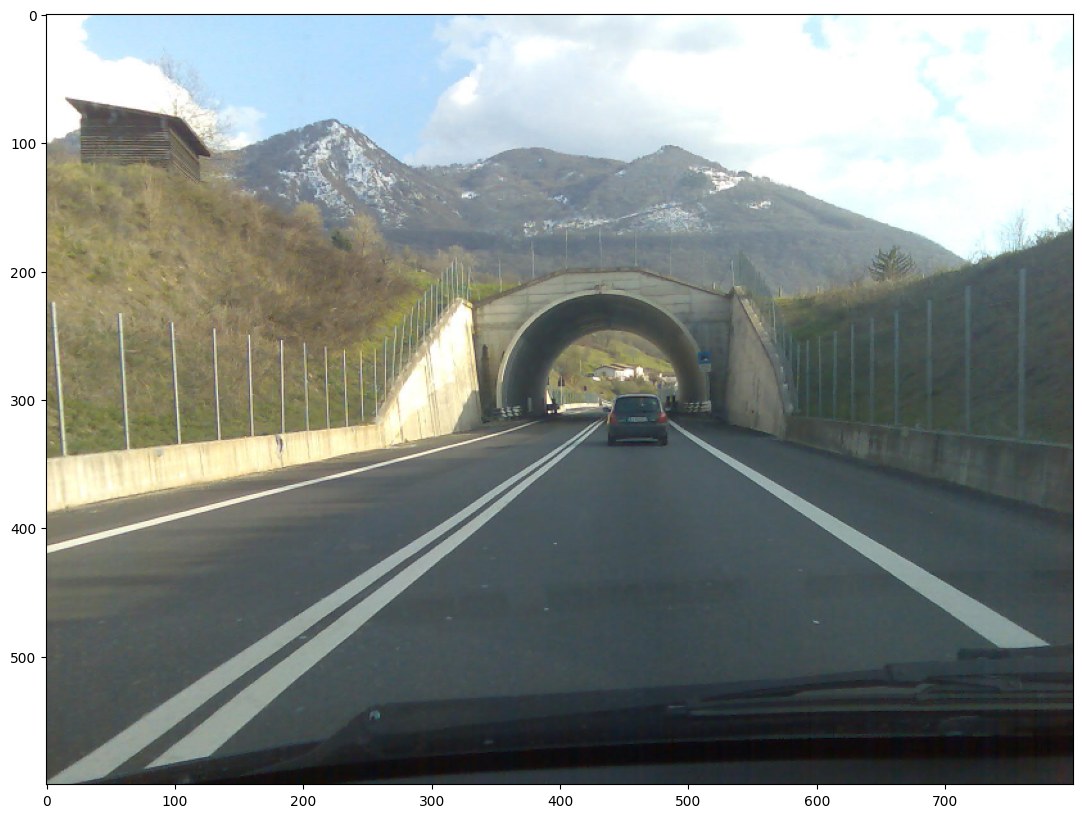

In [2]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, 100, 150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

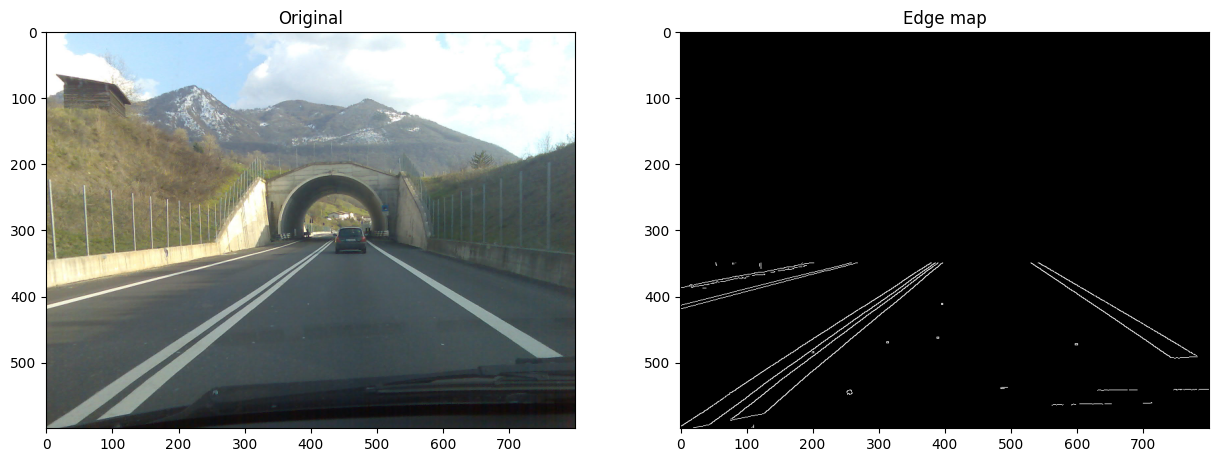

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [109]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, 2, 2*np.pi/180, 190)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

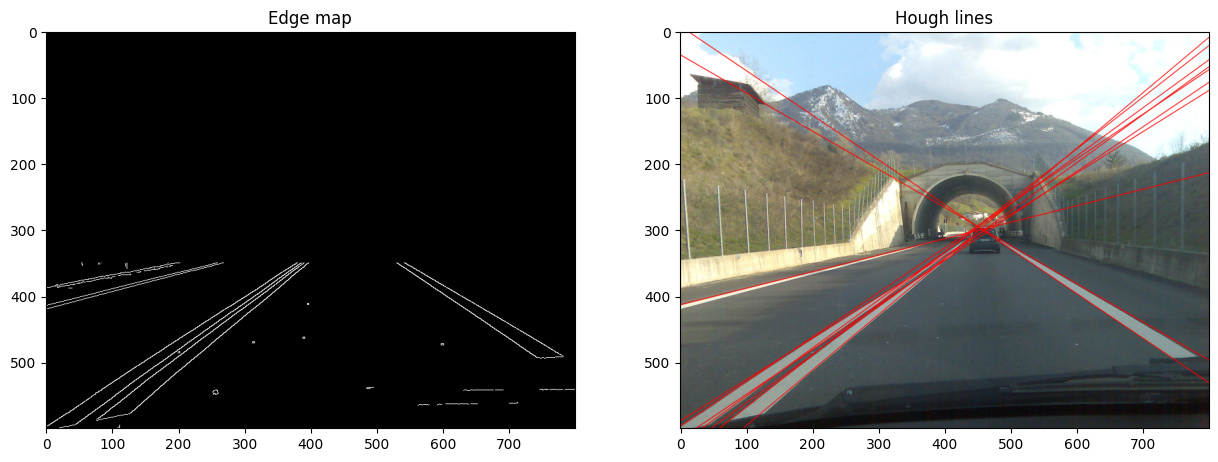

In [110]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [101]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    theta = math.degrees(theta)
    # Keep line if theta is not horizontal
    if not((theta > 70 and theta < 110) or (theta > 250 and theta < 290)):
        filtered_lines.append(line)


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

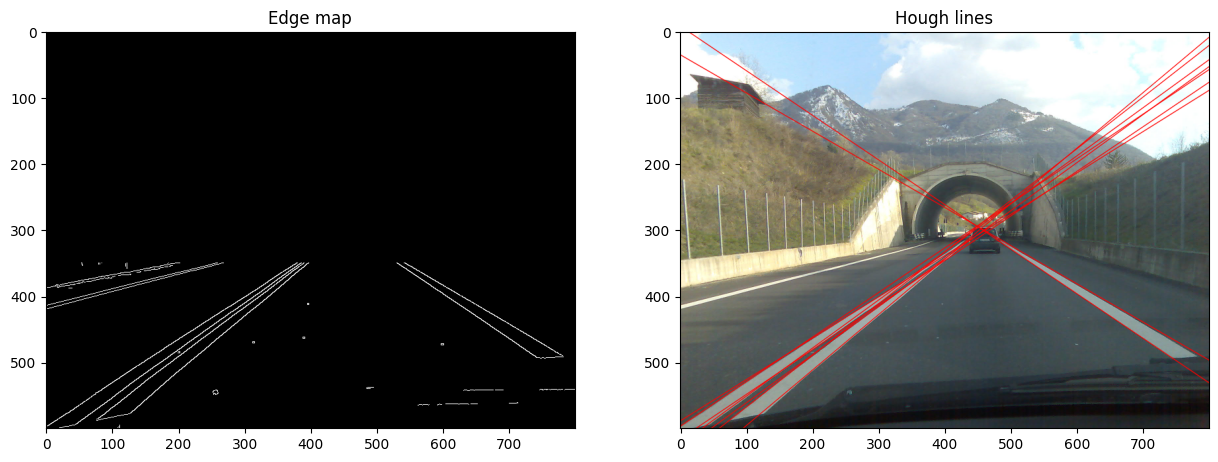

In [102]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [103]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[507.        ,   0.92502448],
       [ -7.        ,   2.16420817],
       [ 31.        ,   2.09439516],
       [497.        ,   0.99483767],
       [521.        ,   0.87266463],
       [512.        ,   0.95993108]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

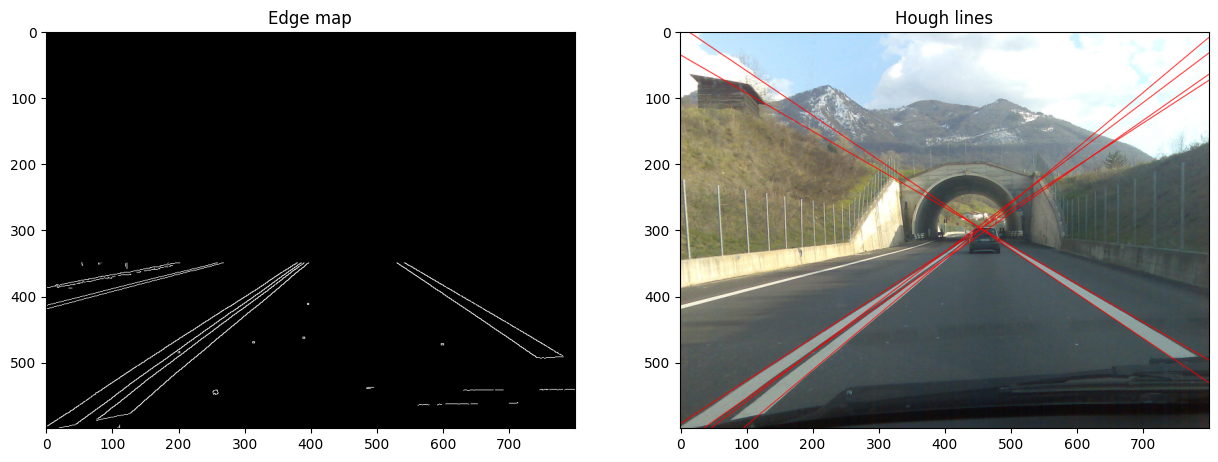

In [104]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?

полученные линии представляют собой центры кластеров, которые не соответствуют в точности какой-либо реальной линии на изображении. это может привести к появлению линий в неожиданных местах или ориентации, которые не совпадают с реальными линиями на изображении. 
так же я заметеил если использовать 1 градус разрешения в Hough transform, то в таком примере "потерялась" одна линий в двойной сполшной (попала в кластер другой), но в правой сплошной полосе появилась третья линия, что тоже может влиять на конечный результат. еще из-за смещения линий у нас точка пересечения их (направление куда машина должна ехать) смещается, что тоже не совсем корректно если задача стоит в удержании машины в полосе.

* Do you think the Hough transform resolution is important for obtaining a good result? Why?

да, конечно. 
например: rho - влияет на то с какой "детализацией" мы получим линии. более высокая деталищация позволяет натйти линии которые близко друг к другу находятся, но это требует больше ресурсов, елси уменьшим детализацию, то получим выше производительность, но менее точный результат. Этот параметр необходимо уже подстраивать от задачи и исходных данных.
theta - насколько точно различать линии (для себя как понял шаг проверки), меньше шаг, больше похожих линий (с похожим углом) появляется, что может нести много "мусора", больше шаг, наоборот, если переборщим, то можем потерять что-то важное. и аналогично к rho, более детальное требует больше мощностьи, меньше деталей - меньше мощности. ну и зависит все от задачи и исх данных :)

* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

да, важно. для того чтобы отсеять линии "шума". чем выше threshold тем больше точек на нам надо на линии чтобы они попали в выборку. Но так же надо принимать в расчет входные данные, если например мы сильно завысим threshold, то при тумане или пасмурной (или дождь/снег) уже дорожная разметка будет иметь не точную пряму и может не попасть в выборку, возможно нужно будет применить USP (3 дом работа) для того чтобы подготовить картинку для Hough transform. Но нужно понимать что нам попадает на вход и уже отталкиваться от этого. но все это затраты мощности, нужно находить баланс, экспериментировать :)